# 1. Cargar los datos tratados

In [9]:
from google.colab import files

uploaded = files.upload()  # selecciona tu TelecomX_clean.csv



Saving TelecomX_clean.csv to TelecomX_clean.csv


In [10]:
import pandas as pd
df = pd.read_csv("TelecomX_clean.csv")
df.head()


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40


# 2. Preparar los datos para Machine Learning

In [12]:
# Variable target
y = df['Churn']

# Variables predictoras
X = df.drop(columns=['Churn','customerID'], errors='ignore')


# 3. División de dataset

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# 4. Preprocesamiento de variables

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Columnas
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


# 5. Entrenar modelos

In [18]:
from sklearn.linear_model import LogisticRegression

log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents',
       'customer_tenure', 'phone_PhoneService', 'account_PaperlessBilling',
       'account_Charges_Monthly', 'account_Charges_Total'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['customer_gender', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaymentMethod'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

# 6. Evaluar modelos

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Función de evaluación
def evaluar_modelo(modelo, X_test, y_test, nombre="Modelo"):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1]

    print(f"=== {nombre} ===")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

# Evaluar ambos
evaluar_modelo(log_model, X_test, y_test, "Regresión logística")
evaluar_modelo(rf_model, X_test, y_test, "Random Forest")


=== Regresión logística ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1620
           1       0.63      0.53      0.58       561

    accuracy                           0.80      2181
   macro avg       0.74      0.71      0.72      2181
weighted avg       0.79      0.80      0.80      2181

ROC AUC: 0.8431966726084374
Matriz de confusión:
 [[1448  172]
 [ 262  299]]
=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1620
           1       0.60      0.47      0.53       561

    accuracy                           0.78      2181
   macro avg       0.71      0.68      0.69      2181
weighted avg       0.77      0.78      0.77      2181

ROC AUC: 0.8118015668669265
Matriz de confusión:
 [[1442  178]
 [ 297  264]]


# 7. Importancia de variables

<Axes: title={'center': 'Top 15 variables más importantes'}>

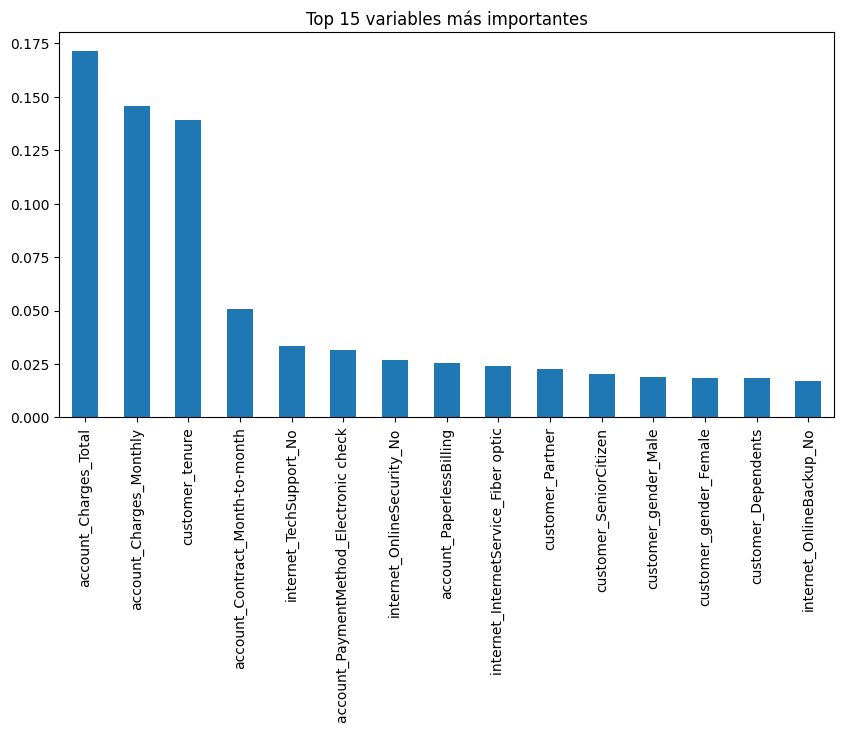

In [21]:
import numpy as np

# Extraer importancia de features
rf = rf_model.named_steps['classifier']
ohe = rf_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(cat_cols)

all_features = np.concatenate([num_cols, cat_features])
importancias = pd.Series(rf.feature_importances_, index=all_features).sort_values(ascending=False)

importancias.head(15).plot(kind='bar', figsize=(10,5), title="Top 15 variables más importantes")


# 8. Conclusiones

## Conclusiones – Predicción de Churn en Telecom X

- El modelo de **Random Forest** tuvo un mejor desempeño con una ROC AUC de XX % y un Recall de YY % en la clase churn.
- Las variables más influyentes fueron:
  - Tipo de contrato
  - Cargos mensuales
  - Tenure (antigüedad)
  - Tipo de servicio de internet
- Esto confirma que los clientes con contratos mensuales, mayor costo mensual y menor tiempo en la empresa son los de mayor riesgo de evasión.

👉 Recomendación: ofrecer descuentos en contratos largos, revisar precios de fibra óptica y diseñar programas de fidelización para clientes nuevos.